## Single locus view plot
The locus view plots are modelled after the popular [LocusZoom](http://locuszoom.org/). These show a zoomed in area of the chromosome with genetic variants plotted according to their -log10(p-value). The points of the plot are coloured according to each variant's LD (r-square) with the lead variant on the plot. The lead variant is usually the top association (most significant p-value) in the region.

Below the scatter plot of genetic variant associations is a track of the genes in the genomic region so the genetic associations can be seen in the context of genomic annotation.

The locus view plots in skyline emulate this and also allow the incorporation of an additional boolean gene annotation grid below the gene track. This allows a simple visualisation of gene information in the context of the plot that can aid things like causal gene designation.

### The imports
We will use the example data to create several locus view plots using the high level `plots.locus_scatter` function. The example data module is not required for normal use, only for this example.

In [1]:
from skyline.example_data import examples

The skyline imports, `skyline.plots` contains the high level plotting functions for the locus view plot. The figure contains the `GenomicFigure` class that is a skyline overide of `matplotlib.Figure`.

In [2]:
from skyline import (
    plots,
    figure,
    coords,
    features
)
from skyline.tracks import scatter
from skyline.patches import genes as gp

[Pandas](https://pandas.pydata.org/) will be used to load the GWAS data and prepare a region for plotting and numpy will be used to -log10 transform the p-values.

In [3]:
import pandas as pd
import numpy as np

The ensembl REST client will be used for gathering some pairwise LD data for the lead variant and the gene annotations for the region

In [4]:
from ensembl_rest_client import client

`matplotlib.backends.backend_agg` is required as some of the plotting components need access to a renderer to autosize text and the default figure creation does not seem to set this up, I am not sure why at the moment.

In [5]:
from matplotlib.backends import backend_agg

This is to display the plots within this notebook. Note that `%matplotlib notebook` does not implement any interactive plots. We have to use the display function to plot as we are not using `pyplot`. However, you can also use `matplotlib.figure.Figure.savefig` to save to file.

In [6]:
# https://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib inline
from IPython.display import display

### Get the example dataset
Load up a small section of GLGC LDL data from chromosome 1 of their 2013 analysis.

In [7]:
test_data = examples.get_data('ldl_locus_view')

### Prepare the input GWAS
The ``test_data`` is almost usable as it is but in case you are using your own data there may be some preparitory steps on the data. Note that `skyline.plots.locus_scatter` expects the pvalues to be log transformed and the data to have columns named:

* `chr_name` - The chromosome name should be a string
* `start_pos` - The start position of the variant - should be an integer
* `effect_allele` - The effect allele of the variant this should be an uppercase string - this is required for the lead variant to be identified in the GWAS data
* `other_allele` - The non-effect allele of the variant this should be an uppercase string - this is required for the lead variant to be identified in the GWAS data.

It also requires the ``pandas.DataFrame`` to have an index containing a universal ID. This is a ``_`` concatination of the ``chr_name``, ``start_pos`` and alleles in sort order. It is not completly universal as indels might have different normalisations and we could have strand issues. However, for most balanced polymorphisms it is good. Our ``test_data`` does not have this so we will create it.

In [8]:
def add_uni_id(df):
    """Simple function to add a "universal identifer" as an index
    in the data frame. This is used internally by locus_view to
    extract the top hit variant.
    
    Parameters
    ----------
    df : `pandas.DataFrame`
        The data frame to add uni_ids to.
        
    Returns
    -------
    df : `pandas.DataFrame`
        The data frame with the uni_ids. The return is not necessary
        as it all happens inplace but it useful for chaining calls.
        
    Notes
    -----
    The universal identifier is a _ concatination of the chr_name,
    start_pos, and alleles in sort order. It is not completly universal
    as indels might have different normalisations and we could have strand
    issues. However, for most balanced polymorphisms it is good.
    """
    # Not the most efficient way but these should be quite small
    df['uni_id'] = df.apply(
        lambda x: "{0}_{1}_{2}_{3}".format(
            x.chr_name, x.start_pos, *sorted([x.effect_allele, x.other_allele]
                                            )
        ),
        axis='columns'
    )
    df.set_index('uni_id', inplace=True)
    # the return is not necessary as it all happens inplace but it useful for
    # chaining calls
    return df

In [9]:
# Add the uni_id index
test_data = add_uni_id(test_data)

In [10]:
test_data

chr_name  start_pos effect_allele other_allele      pvalue
uni_id                                                                    
1_109718619_G_T        1  109718619             G            T    2.491470
1_109718691_G_T        1  109718691             T            G    2.439735
1_109718954_A_G        1  109718954             G            A    2.106349
1_109720385_C_T        1  109720385             T            C    0.525347
1_109720982_A_G        1  109720982             G            A    4.056308
...                  ...        ...           ...          ...         ...
1_109898267_C_G        1  109898267             C            G    2.505428
1_109818158_C_T        1  109818158             T            C  107.267606
1_109833138_A_C        1  109833138             C            A    0.452348
1_109797628_A_C        1  109797628             A            C    2.924088
1_109883576_C_T        1  109883576             T            C    4.151318

[311 rows x 5 columns]

We will also need to define our lead variant in the region. We will create a function for this as well.

In [11]:
def make_lead_variant(df):
    """Make a lead variant tuple from a top hit row from the GWAS.
    
    Parameters
    ----------
    row : `pandas.Series`
        A single top hit row from the GWAS, containing the chr_name,
        start_pos, effect_allele and other_allele columns.
        
    Returns
    -------
    lead_variant : `skyline.features.Variant`
        A variant feature object.
    """
    top_hits = test_data.loc[~np.isinf(test_data['pvalue'])].sort_values('pvalue', ascending=False)
    lead_variant_row = top_hits.iloc[0, ]
    return features.Variant(
        lead_variant_row.chr_name,
        lead_variant_row.start_pos,
        lead_variant_row.effect_allele,
        lead_variant_row.other_allele
    )

In [12]:
lead_var = make_lead_variant(test_data)

You will notice that the lead variant is a custom `Variant` feature object that contains all the information for the variant.

In [13]:
lead_var

<Variant(1:109818530-109818530|1, ref_allele=T, alt_allele=C)>

### Get access to Ensembl via the REST API
For this example we will use the ensembl REST client to get the gene annotations in the region and the pairwise LD with the top hit variants. For this we will use the [ensembl-rest-client](https://gitlab.com/cfinan/ensembl-rest-client) repository. If you have your own LD matrix of the region and/or gene annotations you can use them.

Remeber to use the correct REST URL for the genome build. The `ensembl_rest_client` will default to GRCh38 but this data is GRCh37 so we will need to supply the correct URL.

There are also some utility functions for creating the rest client for different human genome assemblies, see `skyline.ensembl.get_human_b37_rest_client()` and `skyline.ensembl.get_human_b38_rest_client()`.

In [14]:
b37_url = 'https://grch37.rest.ensembl.org'
rc = client.Rest(url=b37_url)

### Plotting a single region
The `skyline.plots.locus_scatter` function can plot multiple regions at once, however, for this example we will just use a single region. We supply the plot data, lead variant and LD information in a `skyline.plots.locus_view.RegionDataContainer` object. So, if you want to plot more than a single region on a plot you can use multiple `RegionDataContainer` objects.

We will output our plot to this notebook but we could also save to an image if we wanted. This example also will show some iterative styling of the plot.

In [15]:
region_data = plots.RegionDataContainer(
    test_data, lead_var, label="LDL",
    # Can be a list of tuple of LD data or a pairwie LD matrix,
    # if not supplied then a rest client should be available
    ld_data=None,
    # Needed for the Ensembl REST API, if ld_data is provided the not required
    population_name='1000GENOMES:phase_3:EUR',
    species='human'
)

#### Parameter initialisation
Set up some of the parameters using in the plot, we define a flank, which is the number of base pairs either side of the start position of our top hit that we land to plot.

In [16]:
# The flanking region around the lead variant that we want to plot
flank = 100000

We will also define a function that will define a region object that dicates the span of the plot

In [17]:
def define_region(lead_var, flank):
    """Define the region around the lead variant that we want to plot.
    
    Parameters
    ----------
    lead_var : `skyline.features.Variant`
        A variant feature object.
    flank : `int`
        The number of base pairs upstreamd and downstream of lead_var.
        
    Returns
    -------
    region : `skyline.features.FeatureCoords`
        The plot region.
    """
    return features.FeatureCoords(
        lead_var.chr_name,
        lead_var.start_pos - flank,
        end_pos=lead_var.end_pos + flank
    )

In [18]:
region = define_region(lead_var, flank)
region

<FeatureCoords(1:109718530-109918530|1)>

The figure dimentions and the dpi, the dimentions are in inches.

In [19]:
figure_width = 6
figure_height = 6
figure_dpi = 300

The `skyline.figure.GenomicFigure` is a special skyline implementation of the matplotlib figure and should be used for all skyline plots. It should be able to be used for regular plotting as well. Note that we are adding a FigureCanvas to our figure. This is required as the gene track autosizes it's text for the gene labels and needs a renderer for that calculation. Currently, I do not know why this is not set internally in `matplotlib` or if this is a skyline specific issue,

In [20]:
# Initialise the figure
gfig = figure.GenomicFigure(
    figsize=(figure_width, figure_height), dpi=figure_dpi
)
# AttributeError: 'FigureCanvasBase' object has no attribute 'get_renderer'
gfig.set_canvas(backend_agg.FigureCanvas(figure=gfig))

The locus view plot is comprised of up to 4 Axes types arranged on a grid. One or more scatter plots `skyline.tracks.scatter.LocusViewScatter`, the gene track `skyline.tracks.genes.GeneTrack`, a linker track `skyline.tracks.linkers.PosToUniformLinkerTrack` and a grid track `skyline.tracks.grids.BooleanGrid`. The linker track and grid track will only be set if an annotation grid is provided.

In [21]:
ruler_length = 1
top_pad_length = 1
scatter_length = 10
genes_length = 5
scatter_gene_gap_length = 1
linker_length = 2
annot_length = 10

Now generate our region for the plot, we define a lead variant as a tuple see `make_lead_variant` function above. extract our region of interest (currently `locus_view` does not do this but this may change in future) and also add a `uni_id` index to our region (again `locus_view` might do this for you in future.

#### First plot
Now we perform our first plot using all the variables that we have defined. See the comments for the specifics.

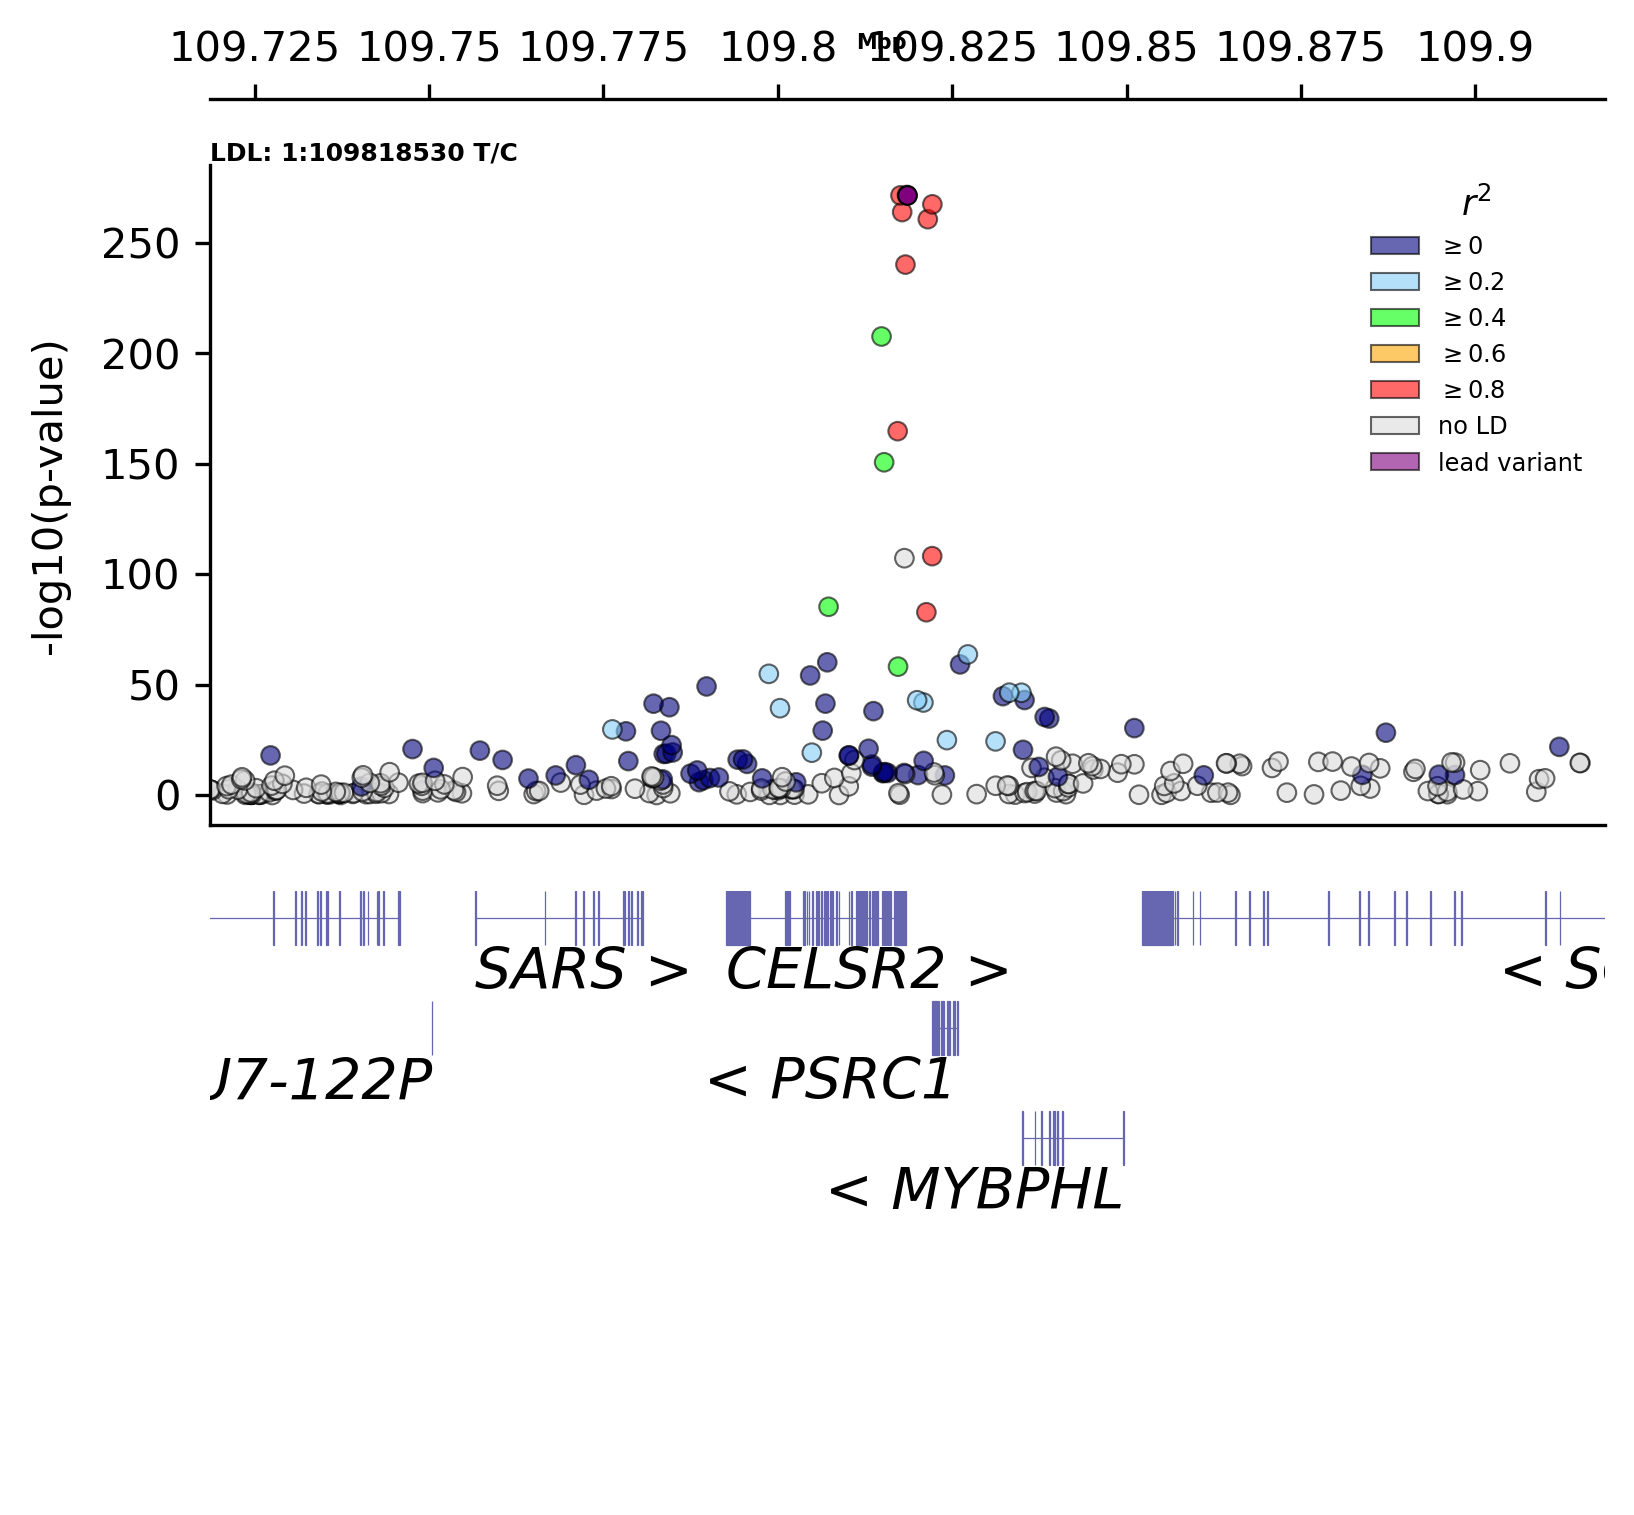

In [22]:
axs, region_data, gene_coords, annot, tracks, subspecs, row_end = plots.locus_scatter(
    # The figure where all the component Axes will be added
    gfig,
    # Our genomic region
    region,
    # The region data and lead variant in the plot, LD will be referenced to this variant
    [region_data],
    ruler_length=ruler_length,
    # A gap at the top of the plot, this will not be evident in the notebook
    # as no Axes are above it
    top_pad_length=top_pad_length,
    # The number of GridSpec rows for the sctter plot
    scatter_length=scatter_length,
    # The number of GridSpec rows for the genes track
    genes_length=genes_length,
    # The number of GridSpec slots between the satter plot and the gene track
    scatter_gene_gap_length=scatter_gene_gap_length,
    # The ensembl rest client object
    rest_client=rc,
    # We do not supply any gene coordinates as we are using the REST client
    # this defaults to NoneType but is shown here for illustration
    gene_coords=None,
    # The biotypes for the genes we want to display, used when the rest client is used
    # to get the genes
    biotypes=None,
)
display(gfig)

### The return values
You will notice that the call to `skyline.plots.locus_view` produces six different return values. These are useful if the user wants to perform any downstream operations on the plotting components, or use any of the data gathered by the function call. Here we will look at these different return values.

#### `axs`
Possibly the most important value that is returned is a tuple of the individual `Axes` that are generated by `skyline.plots.locus_view`. We can view what is inside:

In [23]:
axs

(<BlankTrack: label='SkylineAxes(0)'>,
 <BlankTrack: label='SkylineAxes(1)', ylabel='-log10(p-value)'>,
 <TopRulerTrack: label='SkylineAxes(0)', xlabel='Mbp'>,
 <GeneTrack: label='SkylineAxes(0)'>,
 None,
 None,
 <LocusViewScatter: label='SkylineAxes(0)', xlabel='Mbp'>)

We can decompose, like this:

In [24]:
plot_bottom_blank, scatter_bottom_blank, ruler, gene_track, linker, bool_grid, lv_scatter = axs

All these inherit from `matplotlib.Axes` so you can perform all the usual `matplotlib` operations on them. In the example above `linker` and `bool_grid` will both be `None` as an annotation matrix was not supplied to `locus_view`. However, is it was, then they would be defined.

Also, note that we have plotted a single scatter plot here, if we had plotted more then there would be multiple `LocusViewScatter` objects in the `axs`.

#### `region_data`
This contains the region/LD data that was used for each scatter plot. This may have been supplied by the user to the function call. However, if not, then this will have been downloaded from Ensembl via the REST client. This can be a time consuming process, therefore, this variable can be quite valuable if you want to optimise a plot you can capture it and re-use it in subsequent calls, you you can write it to file, either by pickling it or see `skyline.utils.write_ld_data`.

The structure of the downloaded data is fairly simple and an except is shown below, it is a `list` of `tuples` where each tuple will have 3 items. The first being a `tuple` of the source (lead) variant, the second being a `tuple` of the LD variant and the third being the r-square value between them. Both the source/LD variant tuples have the following elements:
0. chromsome name (`str`)
1. start position (`int`)
2. alleles (`tuple` of `str`) - the order does not matter as these are converted to `uni_ids` (although this may be problematic for palindromic alleles with strand issues)
3. variant ID (`str`) (optional)

In this example we are using LD data from Ensembl and the 1000 genomes EUR superset (`1000GENOMES:phase_3:EUR`). To see all the available populations in Ensembl have a look at the [REST endpoint](https://rest.ensembl.org/documentation/info/variation_populations) for population info. If you have supplied the LD data as an LD matrix with `uni_id` row/column indexes then this will be returned instead.

In [25]:
region_data

[<RegionDataContainer(label='LDL', data=(311,5))>]

We can access the LD data like this

In [26]:
region_data[0].ld_data[:5]

[(('1', 109818530, ('T', 'C'), 'rs646776'),
  ('1', 109783860, ('G', 'A', 'C', 'T'), 'rs12081530'),
  0.104669),
 (('1', 109818530, ('T', 'C'), 'rs646776'),
  ('1', 109784026, ('T', 'C'), 'rs34293021'),
  0.104456),
 (('1', 109818530, ('T', 'C'), 'rs646776'),
  ('1', 109826136, ('C', 'T'), 'rs657420'),
  0.135662),
 (('1', 109818530, ('T', 'C'), 'rs646776'),
  ('1', 109783261, ('T', 'A', 'C'), 'rs11102964'),
  0.098474),
 (('1', 109818530, ('T', 'C'), 'rs646776'),
  ('1', 109820919, ('T', 'G'), 'rs17035949'),
  0.121431)]

#### `gene_coords`
As with the LD data, if the gene coordinates have been queried from Ensembl, then it might be useful to keep hold of them if you are optimising the plot. As with the LD data the structure is simple and an exerpt is shown below:

In [27]:
gene_coords

[<ExonTranscript(1:109852192-109940573|-1, label=SORT1, trans_id=ENSG00000134243, n_exons=20, biotype=protein_coding)>,
 <ExonTranscript(1:109656623-109745851|1, label=KIAA1324, trans_id=ENSG00000116299, n_exons=22, biotype=protein_coding)>,
 <ExonTranscript(1:109792641-109818372|1, label=CELSR2, trans_id=ENSG00000143126, n_exons=34, biotype=protein_coding)>,
 <ExonTranscript(1:109756540-109780742|1, label=SARS, trans_id=ENSG00000031698, n_exons=11, biotype=protein_coding)>,
 <ExonTranscript(1:109834987-109849663|-1, label=MYBPHL, trans_id=ENSG00000221986, n_exons=9, biotype=protein_coding)>,
 <ExonTranscript(1:109822179-109825790|-1, label=PSRC1, trans_id=ENSG00000134222, n_exons=8, biotype=protein_coding)>,
 <ExonTranscript(1:109750416-109750470|-1, label=RNU7-122P, trans_id=ENSG00000238310, n_exons=1, biotype=snRNA)>]

`gene_coords` is a `list` of `tuples`, where each tuple represents a gene on the plot. The gene tuples have the following elements:

0. chromosome name (`str`)
1. `list` of `tuples` representing the exon structure, where each exon tuple has the structure (`start_pos` (`int`), `end_pos` (`int`), `is_coding` (`bool`)).
2. The strand (`int`) either 1 or -1
3. The gene name (`str`)

There is a possibility to supply `gene_coords` with a styling object at `[4]` to change the individual styling parameters of the genes but this has not been tested yet.

#### `annot`
The annotation grid (matrix) used. This is returned as `locus_view` may alter the orignal to place to the genes in their positional order on the chromosome, so the column order may well be different to the matrix that was passed. This is a `pandas.DataFrame` with the annotation category text as rows and the gene names as columns. If the gene has an annotaton then it will be `True` otherwise it will be `False`.

#### `tracks`
This is the `matplotlib.gridspec.GridSpec` object that was used to place the tracks. It may be that the user supplied their own object to the function call, in which case the same one is returned. However, if not, then it is created internally and returned.

#### `subspecs`

In [28]:
subspecs

[]

#### `row_end`
This is an integer value of the last `GridSpec` slot that was used when plotting the locus view plot, this is useful if you want to plot multiple plots as you can supply this value back as the `row_start` argument with subsequent calls (and if you are providing your own `GridSpec` object to place everything on). Although, using a plotting grid is easier than this approach.

In [29]:
row_end

17

### Changing the appearance 
Currently, in this context the default x-axis tick labels do are too big. There fore we can use the returned Axes objects to make some changes. In general, skyline uses the regular matplotlib methods for handling the Axis appearance unless there is something specific for the plot. So we will re-display our plot again and reduce the Axis text size. This time we will also use our previously downloaded gene coordinate data and LD data, so we do not need to supply the REST client, although it would not produce an error if we did supply it.

In [30]:
def size_axis(axs, labelsize=5):
    """Resize the axis labels on the plot. I will be doing this a
    few times so it is functioned off.
    
    Parameters
    ----------
    axs : `tuple`
        The Axes from a call to `skyline.plots.locus_view`
    labelsize :`int`, optional, default: 5
        The required size of the tick/y-axis labels
    """
    # Decompose the returned Axes
    plot_bottom_blank, scatter_bottom_blank, ruler, gene_track, linker, bool_grid, lv_scatter = axs
    
    # Sort out the axis sizes on the scatter plot
    ruler.xaxis.set_tick_params(labelsize=labelsize)
    lv_scatter.yaxis.set_tick_params(labelsize=labelsize)
    lv_scatter.yaxis.label.set_size(labelsize)

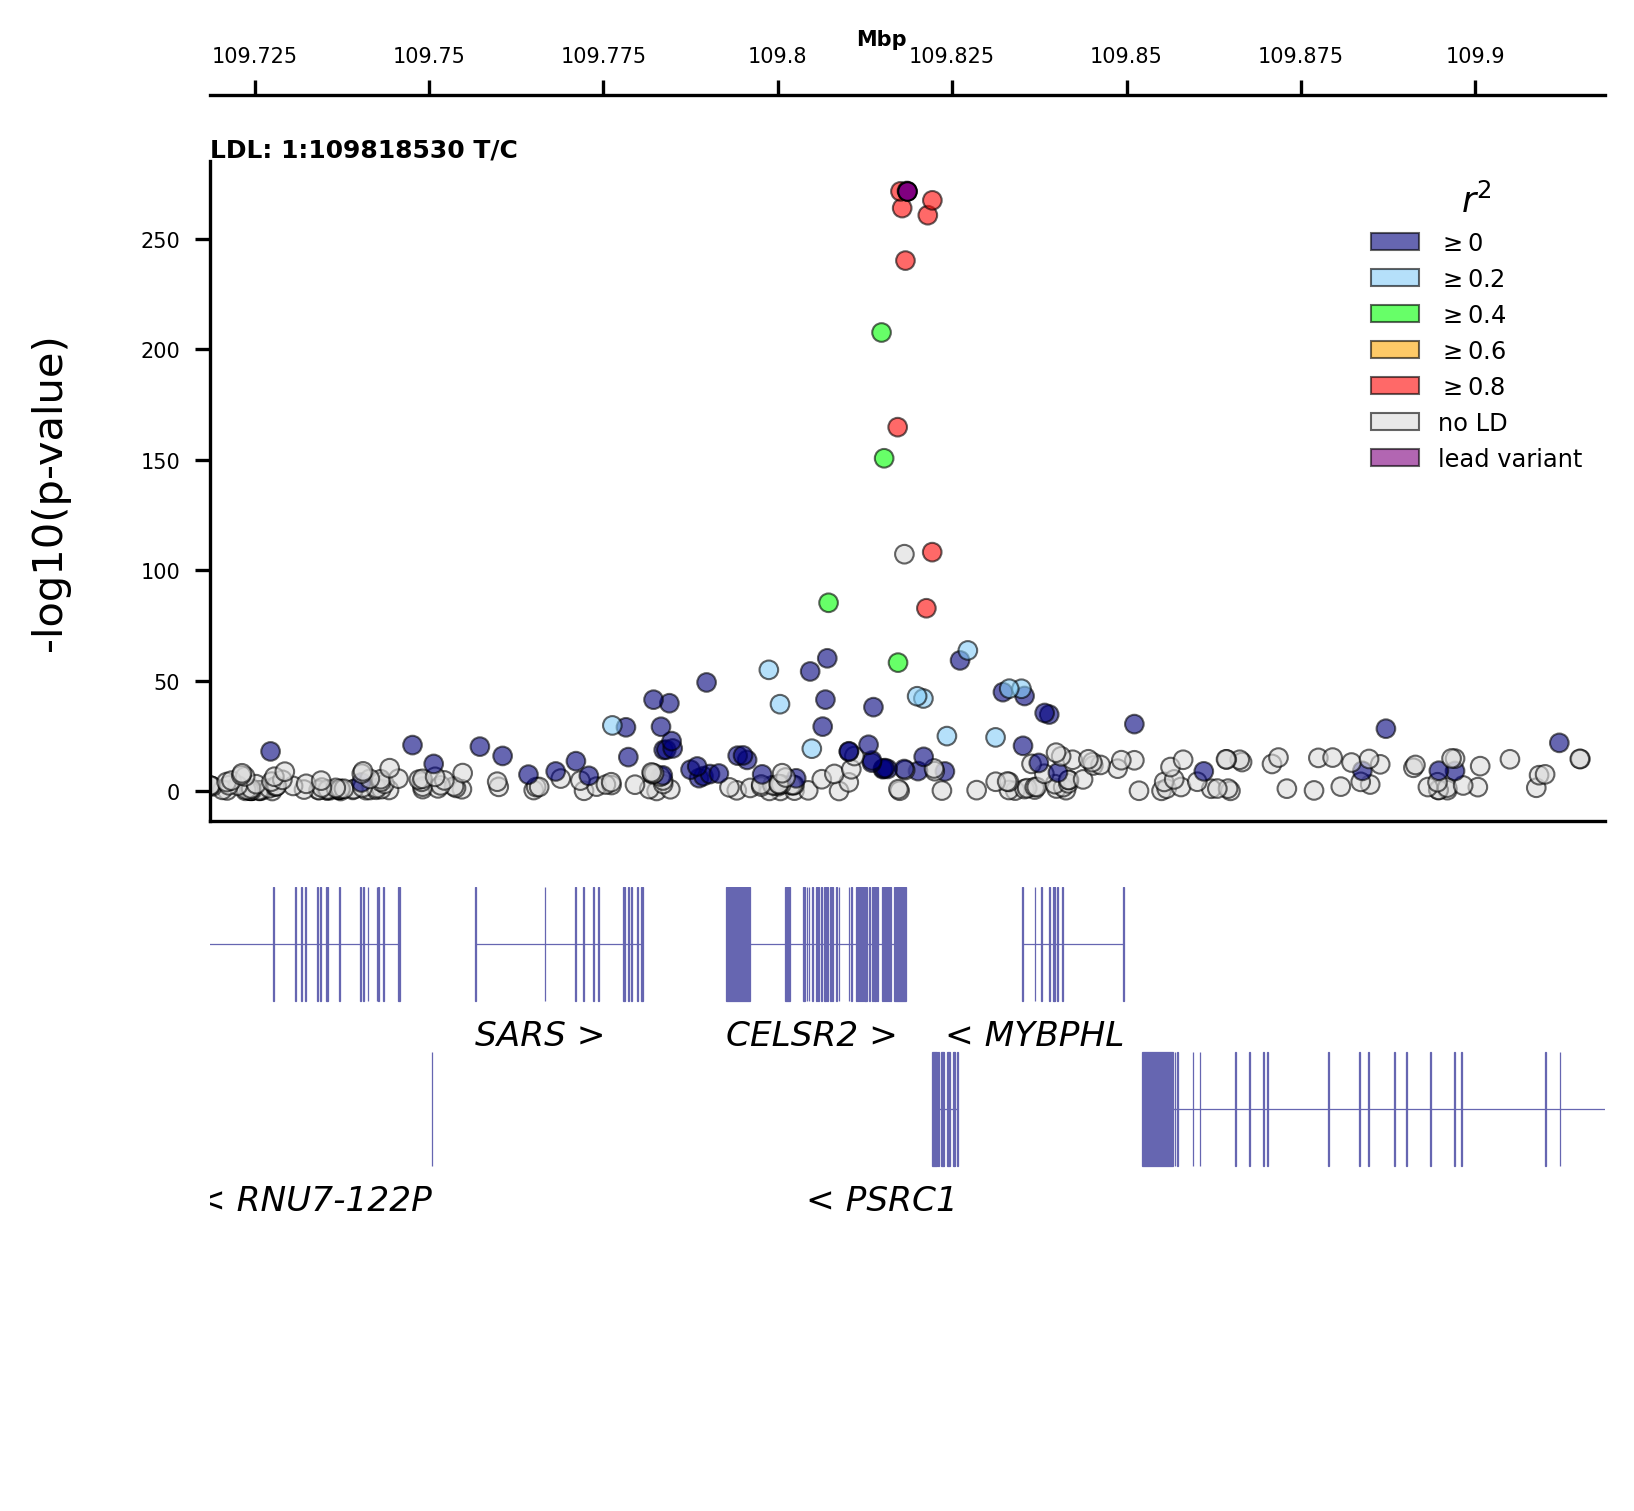

In [31]:
gfig.clear()
for i in gene_coords:
    i.delete_coords_mapper()

axs, region_data, gene_coords, annot, tracks, subspecs, row_end = plots.locus_scatter(
    gfig,
    region,
    region_data,
    ruler_length=ruler_length,
    top_pad_length=top_pad_length,
    scatter_length=scatter_length,
    genes_length=genes_length,
    scatter_gene_gap_length=scatter_gene_gap_length,
    # Use the gene coordinate data from the last call
    gene_coords=gene_coords,
    gene_label_height=0.3
)
size_axis(axs)
display(gfig)

We can change more than just the Axis label sizes. We can change the individual plotting components via the call to `skyline.plots.locus_view`. Below illustrates some of these concepts.

In the plot above you will notice that the placement of the **Mbp** units is in the bottom left and not quite aligned with the rest of the Axis tick labels. This is difficult to get correct but we can alter it by providing new positional units in Axes cordinates. So we will move to the right hand side and shift it up a bit.

In [32]:
# The coordinates for the unit of the x-axis are given in Axes
# coordinates not data coordinates
unit_text_coords=(1.01, 1.5)

We might also decide that the intron/exon structure of the gene is not particularly useful (particularly if larger regions are being plotted). Therefore we can assign a different gene style to use. The style of the gene is referred to as a patch which is a low level matplotlib plotting symbol, i.e. a rectangle or other polygons. The genes are implemented as subclasses of [`matplotlib.patches.PathPatch`](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.PathPatch.html). Currently there are only two gene patch styles, `skyline.patches.genes.ExonGene` and `skyline.patches.genes.BlockGene`, more syles will eventually be written and the user can implement they own style classes if they wish. In this example we will change the gene patch to use `skyline.patches.genes.BlockGene`, to do this we simply supply the class name of the gene patch.

In [33]:
gene_patch=gp.BlockGene

In addition to changing how the gene is structured we can also change it's colours by specifing the styling parameters applicable for [`matplotlib.patches.PathPatch`](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.PathPatch.html), the most common of which will be `edgecolor` and `facecolor`.

In [34]:
gene_patch_style = dict(facecolor='#3D3D3D80', edgecolor='black')

The `skyline.patches.genes.BlockGene` have directional arrow heads accordind to their strand. The distance that these travel back into to a gene can be determined by breakpoints that are given in base pairs. So in the two break points supplied below. If a gene is >= 5000 bp long it will have an arrow starting at 5000 until the end of the gene. If it is >= 1000 basepairs long (and less than 5000, it will have an arrowhead starting 1000 basepairs from the end to the end of the gene. You can add as many breakpoints as you wnat to this list. This is mainly to avoid a arrowhead that is continiously proportional to the length of the gene.

In [35]:
gene_patch_pointbreaks = [1000, 2000]

As the genes now have their own arrowheads it seems overkill to have them in the labels as well, so these can be turned off.

In [36]:
gene_label_dir=False

Having a plain white gene background may not always be desirable. Therefore, the gene track of the locus view is able to take arguments for alternating background row colours. These are cycled through. To supply these dictionaries of parameters to `matplotlib.Axes.axhspan` should be supplied in a list.

In [37]:
gene_row_colors = [
    dict(edgecolor='none', facecolor='none'),
    dict(edgecolor='none', facecolor='lightgrey', alpha=0.5)
]

Adding row backgrounds makes the genes touch the edge of the rows, to make it look better we can add some padding to the top and bottom of each gene row, this should be a value between 0-1.

In [38]:
gene_row_pad = 0.1

Now we have defined all the things we want to change we will call `skyline.plots.locus_view` again with the changes. Obvioulsy we could have passed these stright to the call without pre-decaring them, but it is sometimes cleaner to pre-decleare with comments first.

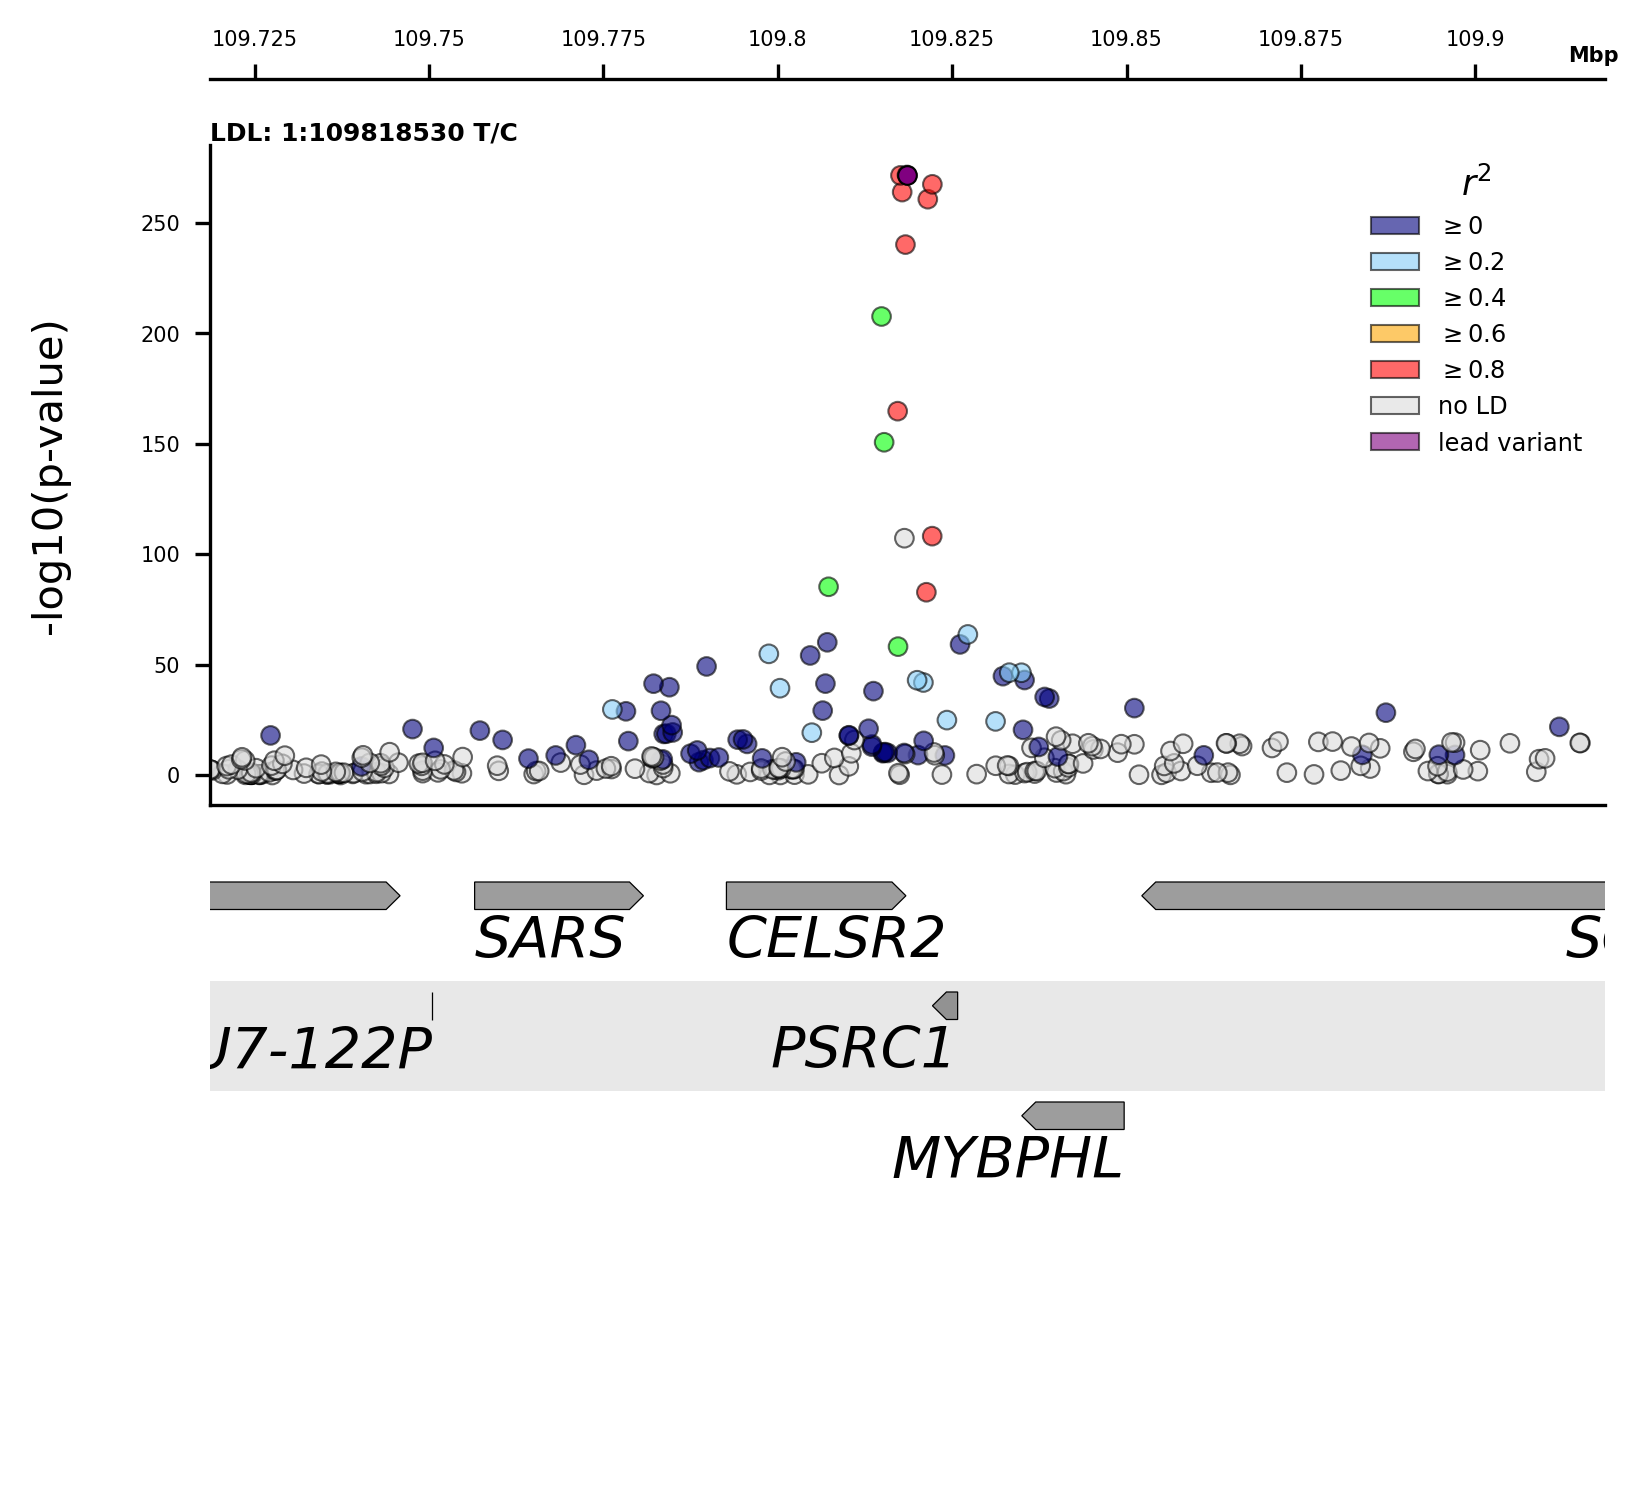

In [40]:
gfig.clear()
for i in gene_coords:
    i.delete_coords_mapper()

axs, region_data, gene_coords, annot, tracks, subspecs, row_end = plots.locus_scatter(
    gfig,
    region,
    region_data,
    ruler_length=ruler_length,
    top_pad_length=top_pad_length,
    scatter_length=scatter_length,
    genes_length=genes_length,
    scatter_gene_gap_length=scatter_gene_gap_length,
    gene_coords=gene_coords,
    # Change the position of Mbp
    ruler_unit_text_coords=unit_text_coords,
    # Use block gene patches
    gene_patch=gene_patch,
    # Change the line colors and background colours of the block genes
    gene_patch_style=gene_patch_style,
    # Change the pitch of the arrow heads
    gene_patch_pointbreaks=gene_patch_pointbreaks,
    # Remove the directional symbols from the gene labels
    gene_label_dir=gene_label_dir,
    # Add alternating background colours to the various gene rows
    gene_row_style=gene_row_colors,
    # Add some padding to the genes so they do not touch the
    # sides of the gene row
    gene_row_pad=gene_row_pad,
    gene_label_pad=0.05
)
size_axis(axs)
display(gfig)

### Summary
These examples demonstrate some of the basic functionality of locus view plots in skyline. There are many other things that can be changed such as LD breakpoints and colours. It is also possible to change the colours of individual genes (although this has not been tested at all yet).

We also have not demostrated adding an annotation grid to the plot. I will update this example in the near future to incorporate that.

We have also only used a simple scenario of plotting a single region. It is possible to make composites of multiple locus views per figure and there is also a dedicated class for producing PDF outputs of locus view plotsthat can be used as appendices in publications. These topics are/will be covered in other examples.